In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pprint import pprint
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LeakyReLU, Dropout, BatchNormalization
from keras.losses import mean_squared_error, binary_crossentropy
from keras.optimizers import Adam, RMSprop
from keras import metrics
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers

Using TensorFlow backend.


In [3]:
start = datetime(2000,1,1)
end = datetime(2016,1,1)

In [4]:
# original_data = pdr.get_data_yahoo('SPY', start, end)
# original_data.drop(['Volume', 'Adj Close'], axis=1, inplace=True)

In [5]:
# original_data.to_pickle('SPY.pkl')

In [6]:
original_data = pd.read_pickle('SPY.pkl')

In [7]:
original_data.head()

,Open,High,Low,Close
Date,,,,
1999-12-31,146.843704,147.500000,146.250000,146.8750
2000-01-03,148.250000,148.250000,143.875000,145.4375
2000-01-04,143.531204,144.062500,139.640594,139.7500
2000-01-05,139.937500,141.531204,137.250000,140.0000
2000-01-06,139.625000,141.500000,137.750000,137.7500


### Create data representation

In [8]:
max_shift = 10

In [9]:
data = original_data.copy()
data.columns = pd.MultiIndex.from_product([['Shift 0'],['Open','High','Low','Close']])
for i in range(1, max_shift + 1):
    shifted = data.iloc[:,[0,1,2,3]].shift(i)
    shifted.columns = pd.MultiIndex.from_product([['Shift ' + str(i)],['Open','High','Low','Close']])
    data = pd.concat([data, shifted], axis=1)

In [10]:
data.head(6)

Shift 0                                       Shift 1  \
                  Open        High         Low     Close        Open   
Date                                                                   
1999-12-31  146.843704  147.500000  146.250000  146.8750         NaN   
2000-01-03  148.250000  148.250000  143.875000  145.4375  146.843704   
2000-01-04  143.531204  144.062500  139.640594  139.7500  148.250000   
2000-01-05  139.937500  141.531204  137.250000  140.0000  143.531204   
2000-01-06  139.625000  141.500000  137.750000  137.7500  139.937500   
2000-01-07  140.312500  145.750000  140.062500  145.7500  139.625000   

                                                 Shift 2              ...   \
                  High         Low     Close        Open        High  ...    
Date                                                                  ...    
1999-12-31         NaN         NaN       NaN         NaN         NaN  ...    
2000-01-03  147.500000  146.250000  146.8750         NaN         NaN  ...    
2000-01-04  148.250000  143.875000  145.4375  146.843704  147.500000  ...    
2000-01-05  144.062500  139.640594  139.7500  148.250000  148.250000  ...    
2000-01-06  141.531204  137.250000  140.0000  143.531204  144.062500  ...    
2000-01-07  141.500000  137.750000  137.7500  139.937500  141.531204  ...    

           Shift 8       Shift 9                Shift 10                 
               Low Close    Open High Low Close     Open High Low Close  
Date                                                                     
1999-12-31     NaN   NaN     NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-03     NaN   NaN     NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-04     NaN   NaN     NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-05     NaN   NaN     NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-06     NaN   NaN     NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-07     NaN   NaN     NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  

[6 rows x 44 columns]

In [11]:
data['Shift 2', 'Close'].head(3)

Date
1999-12-31        NaN
2000-01-03        NaN
2000-01-04    146.875
Name: (Shift 2, Close), dtype: float64

In [12]:
for i in range(0, max_shift):
    cls = data['Shift ' + str(i), 'Close']
    opn = data['Shift ' + str(i), 'Open']
    data['Shift ' + str(i), 'Bull ' + str(i)] = 100 * (cls - opn) / cls

In [13]:
data['Shift 0'].head(2)

,Open,High,Low,Close,Bull 0
Date,,,,,
1999-12-31,146.843704,147.50,146.250,146.8750,0.021308
2000-01-03,148.250000,148.25,143.875,145.4375,-1.933820


In [14]:
for i in range(0, max_shift):
    opn = data['Shift ' + str(i), 'Open']
    prv_cls = data['Shift ' + str(i+1), 'Close']
    data['Shift ' + str(i), 'GT ' + str(i)] = 100 * (opn - prv_cls) / opn

In [15]:
data[['Shift 0', 'Shift 1']].head()

Shift 0                                                        \
                  Open        High         Low     Close    Bull 0      GT 0   
Date                                                                           
1999-12-31  146.843704  147.500000  146.250000  146.8750  0.021308       NaN   
2000-01-03  148.250000  148.250000  143.875000  145.4375 -1.933820  0.927487   
2000-01-04  143.531204  144.062500  139.640594  139.7500 -2.705692 -1.328140   
2000-01-05  139.937500  141.531204  137.250000  140.0000  0.044643  0.133988   
2000-01-06  139.625000  141.500000  137.750000  137.7500 -1.361162 -0.268577   

               Shift 1                                                        
                  Open        High         Low     Close    Bull 1      GT 1  
Date                                                                          
1999-12-31         NaN         NaN         NaN       NaN       NaN       NaN  
2000-01-03  146.843704  147.500000  146.250000  146.8750  0.021308       NaN  
2000-01-04  148.250000  148.250000  143.875000  145.4375 -1.933820  0.927487  
2000-01-05  143.531204  144.062500  139.640594  139.7500 -2.705692 -1.328140  
2000-01-06  139.937500  141.531204  137.250000  140.0000  0.044643  0.133988

In [16]:
shifted = data.iloc[:,[0,1,2,3]].shift(-5)
shifted.columns = pd.MultiIndex.from_product([['Shift -5'],['Open','High','Low','Close']])
data = pd.concat([data, shifted], axis=1)

In [17]:
cls_5 = data['Shift -5', 'Close']
cls = data['Shift 0', 'Close']
data['Shift 0', 'Return'] = 100 * (cls_5 - cls) / cls_5
data.head()

Shift 0                                       Shift 1  \
                  Open        High         Low     Close        Open   
Date                                                                   
1999-12-31  146.843704  147.500000  146.250000  146.8750         NaN   
2000-01-03  148.250000  148.250000  143.875000  145.4375  146.843704   
2000-01-04  143.531204  144.062500  139.640594  139.7500  148.250000   
2000-01-05  139.937500  141.531204  137.250000  140.0000  143.531204   
2000-01-06  139.625000  141.500000  137.750000  137.7500  139.937500   

                                                 Shift 2              ...     \
                  High         Low     Close        Open      High    ...      
Date                                                                  ...      
1999-12-31         NaN         NaN       NaN         NaN       NaN    ...      
2000-01-03  147.500000  146.250000  146.8750         NaN       NaN    ...      
2000-01-04  148.250000  143.875000  145.4375  146.843704  147.5000    ...      
2000-01-05  144.062500  139.640594  139.7500  148.250000  148.2500    ...      
2000-01-06  141.531204  137.250000  140.0000  143.531204  144.0625    ...      

           Shift 5 Shift 6 Shift 7 Shift 8 Shift 9    Shift -5              \
              GT 5    GT 6    GT 7    GT 8    GT 9        Open        High   
Date                                                                         
1999-12-31     NaN     NaN     NaN     NaN     NaN  140.312500  145.750000   
2000-01-03     NaN     NaN     NaN     NaN     NaN  146.250000  146.906204   
2000-01-04     NaN     NaN     NaN     NaN     NaN  145.812500  146.093704   
2000-01-05     NaN     NaN     NaN     NaN     NaN  144.593704  144.593704   
2000-01-06     NaN     NaN     NaN     NaN     NaN  144.468704  145.750000   

                                   Shift 0  
                   Low     Close    Return  
Date                                        
1999-12-31  140.062500  145.7500 -0.771870  
2000-01-03  145.031204  146.2500  0.555556  
2000-01-04  143.500000  144.5000  3.287197  
2000-01-05  142.875000  143.0625  2.140673  
2000-01-06  143.281204  145.0000  5.000000  

[5 rows x 69 columns]

In [18]:
binary_data = data.drop(['Open', 'High', 'Low', 'Close'], axis=1, level=1)
binary_data.head()

,Shift 0,Shift 1,Shift 2,Shift 3,Shift 4,Shift 5,Shift 6,Shift 7,Shift 8,Shift 9,...,Shift 1,Shift 2,Shift 3,Shift 4,Shift 5,Shift 6,Shift 7,Shift 8,Shift 9,Shift 0
,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 1,GT 2,GT 3,GT 4,GT 5,GT 6,GT 7,GT 8,GT 9,Return
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.771870
2000-01-03,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555556
2000-01-04,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.927487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.287197
2000-01-05,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.328140,0.927487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.140673
2000-01-06,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,...,0.133988,-1.328140,0.927487,NaN,NaN,NaN,NaN,NaN,NaN,5.000000


In [19]:
binary_data.columns = binary_data.columns.droplevel()

In [20]:
binary_data.head(10)

,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 1,GT 2,GT 3,GT 4,GT 5,GT 6,GT 7,GT 8,GT 9,Return
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.771870
2000-01-03,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555556
2000-01-04,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.927487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.287197
2000-01-05,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.328140,0.927487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.140673
2000-01-06,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,NaN,...,0.133988,-1.328140,0.927487,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
2000-01-07,3.730703,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,NaN,...,-0.268577,0.133988,-1.328140,0.927487,NaN,NaN,NaN,NaN,NaN,0.829227
2000-01-10,0.000000,3.730703,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,...,1.826281,-0.268577,0.133988,-1.328140,0.927487,NaN,NaN,NaN,NaN,-0.300043
2000-01-11,-0.908304,0.000000,3.730703,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,...,0.341880,1.826281,-0.268577,0.133988,-1.328140,0.927487,NaN,NaN,NaN,1.700680
2000-01-12,-1.070304,-0.908304,0.000000,3.730703,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,...,-0.300043,0.341880,1.826281,-0.268577,0.133988,-1.328140,0.927487,NaN,NaN,1.165803


# Train Keras NN

### Setup X_train, X_test, etc

In [21]:
binary_data.dropna(inplace=True)

In [22]:
X = binary_data.drop('Return', axis=1)
y = binary_data['Return'] > 0
y = np.expand_dims(y, axis=1)
y = np.hstack((y, 1 - y))

In [23]:
returns = binary_data['Return']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Build model

In [26]:
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(80, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(80, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(50, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(25, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(2, kernel_initializer='uniform'))
model.add(Activation('softmax'))

model.compile(optimizer=Adam(lr=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=2000, 
          batch_size=256, 
          verbose=2)

Train on 3208 samples, validate on 803 samples
Epoch 1/3000
3s - loss: 0.6951 - acc: 0.5228 - val_loss: 0.6880 - val_acc: 0.6040
Epoch 2/3000
0s - loss: 0.6928 - acc: 0.5321 - val_loss: 0.6870 - val_acc: 0.6040
Epoch 3/3000
0s - loss: 0.6886 - acc: 0.5343 - val_loss: 0.6854 - val_acc: 0.6040
Epoch 4/3000
0s - loss: 0.6858 - acc: 0.5589 - val_loss: 0.6850 - val_acc: 0.6040
Epoch 5/3000
0s - loss: 0.6821 - acc: 0.5639 - val_loss: 0.6843 - val_acc: 0.6040
Epoch 6/3000
0s - loss: 0.6799 - acc: 0.5739 - val_loss: 0.6831 - val_acc: 0.6040
Epoch 7/3000
0s - loss: 0.6755 - acc: 0.5867 - val_loss: 0.6802 - val_acc: 0.5990
Epoch 8/3000
0s - loss: 0.6730 - acc: 0.5863 - val_loss: 0.6841 - val_acc: 0.5791
Epoch 9/3000
0s - loss: 0.6693 - acc: 0.5857 - val_loss: 0.6780 - val_acc: 0.5928
Epoch 10/3000
0s - loss: 0.6657 - acc: 0.5994 - val_loss: 0.6856 - val_acc: 0.5504
Epoch 11/3000
0s - loss: 0.6551 - acc: 0.6119 - val_loss: 0.6781 - val_acc: 0.5579
Epoch 12/3000
0s - loss: 0.6636 - acc: 0.6069 - v

0s - loss: 0.4142 - acc: 0.8046 - val_loss: 0.8623 - val_acc: 0.5455
Epoch 101/3000
0s - loss: 0.4333 - acc: 0.8011 - val_loss: 0.8346 - val_acc: 0.5380
Epoch 102/3000
0s - loss: 0.4160 - acc: 0.8155 - val_loss: 0.8387 - val_acc: 0.5392
Epoch 103/3000
0s - loss: 0.4109 - acc: 0.8052 - val_loss: 0.8547 - val_acc: 0.5367
Epoch 104/3000
0s - loss: 0.4224 - acc: 0.8067 - val_loss: 0.8994 - val_acc: 0.5355
Epoch 105/3000
0s - loss: 0.4109 - acc: 0.8089 - val_loss: 0.8624 - val_acc: 0.5330
Epoch 106/3000
0s - loss: 0.4150 - acc: 0.8095 - val_loss: 0.8890 - val_acc: 0.5479
Epoch 107/3000
0s - loss: 0.4155 - acc: 0.8114 - val_loss: 0.8603 - val_acc: 0.5355
Epoch 108/3000
0s - loss: 0.4266 - acc: 0.8080 - val_loss: 0.8196 - val_acc: 0.5218
Epoch 109/3000
0s - loss: 0.4128 - acc: 0.8067 - val_loss: 0.8347 - val_acc: 0.5330
Epoch 110/3000
0s - loss: 0.4065 - acc: 0.8105 - val_loss: 0.8532 - val_acc: 0.5330
Epoch 111/3000
0s - loss: 0.4193 - acc: 0.8092 - val_loss: 0.8286 - val_acc: 0.5367
Epoch 1

0s - loss: 0.3559 - acc: 0.8410 - val_loss: 0.9801 - val_acc: 0.5168
Epoch 199/3000
0s - loss: 0.3646 - acc: 0.8273 - val_loss: 0.9513 - val_acc: 0.5168
Epoch 200/3000
0s - loss: 0.3585 - acc: 0.8351 - val_loss: 0.9533 - val_acc: 0.5230
Epoch 201/3000
0s - loss: 0.3880 - acc: 0.8201 - val_loss: 0.9093 - val_acc: 0.5268
Epoch 202/3000
0s - loss: 0.3666 - acc: 0.8404 - val_loss: 0.9574 - val_acc: 0.5455
Epoch 203/3000
0s - loss: 0.3669 - acc: 0.8398 - val_loss: 0.9261 - val_acc: 0.5380
Epoch 204/3000
0s - loss: 0.3643 - acc: 0.8301 - val_loss: 0.9476 - val_acc: 0.5492
Epoch 205/3000
0s - loss: 0.3564 - acc: 0.8463 - val_loss: 0.9679 - val_acc: 0.5355
Epoch 206/3000
0s - loss: 0.3512 - acc: 0.8441 - val_loss: 0.9694 - val_acc: 0.5479
Epoch 207/3000
0s - loss: 0.3492 - acc: 0.8398 - val_loss: 0.9704 - val_acc: 0.5380
Epoch 208/3000
0s - loss: 0.3644 - acc: 0.8360 - val_loss: 0.9507 - val_acc: 0.5392
Epoch 209/3000
0s - loss: 0.3666 - acc: 0.8314 - val_loss: 0.9290 - val_acc: 0.5330
Epoch 2

0s - loss: 0.3274 - acc: 0.8557 - val_loss: 0.9749 - val_acc: 0.5554
Epoch 298/3000
0s - loss: 0.3340 - acc: 0.8600 - val_loss: 0.9932 - val_acc: 0.5504
Epoch 299/3000
0s - loss: 0.3272 - acc: 0.8550 - val_loss: 1.0072 - val_acc: 0.5629
Epoch 300/3000
0s - loss: 0.3360 - acc: 0.8466 - val_loss: 1.0363 - val_acc: 0.5479
Epoch 301/3000
0s - loss: 0.3354 - acc: 0.8544 - val_loss: 1.0370 - val_acc: 0.5554
Epoch 302/3000
0s - loss: 0.3361 - acc: 0.8557 - val_loss: 1.0902 - val_acc: 0.5467
Epoch 303/3000
0s - loss: 0.3399 - acc: 0.8448 - val_loss: 1.0007 - val_acc: 0.5318
Epoch 304/3000
0s - loss: 0.3429 - acc: 0.8560 - val_loss: 0.9739 - val_acc: 0.5367
Epoch 305/3000
0s - loss: 0.3288 - acc: 0.8538 - val_loss: 1.0333 - val_acc: 0.5455
Epoch 306/3000
0s - loss: 0.3387 - acc: 0.8491 - val_loss: 0.9994 - val_acc: 0.5579
Epoch 307/3000
0s - loss: 0.3360 - acc: 0.8491 - val_loss: 1.0232 - val_acc: 0.5492
Epoch 308/3000
0s - loss: 0.3248 - acc: 0.8582 - val_loss: 1.0267 - val_acc: 0.5430
Epoch 3

0s - loss: 0.3159 - acc: 0.8669 - val_loss: 1.0063 - val_acc: 0.5567
Epoch 397/3000
0s - loss: 0.3366 - acc: 0.8541 - val_loss: 0.9761 - val_acc: 0.5455
Epoch 398/3000
0s - loss: 0.3180 - acc: 0.8622 - val_loss: 0.9953 - val_acc: 0.5567
Epoch 399/3000
0s - loss: 0.3294 - acc: 0.8535 - val_loss: 0.9760 - val_acc: 0.5479
Epoch 400/3000
0s - loss: 0.3273 - acc: 0.8519 - val_loss: 0.9811 - val_acc: 0.5380
Epoch 401/3000
0s - loss: 0.3284 - acc: 0.8625 - val_loss: 1.0056 - val_acc: 0.5430
Epoch 402/3000
0s - loss: 0.3297 - acc: 0.8547 - val_loss: 0.9554 - val_acc: 0.5479
Epoch 403/3000
0s - loss: 0.3009 - acc: 0.8647 - val_loss: 1.0186 - val_acc: 0.5455
Epoch 404/3000
0s - loss: 0.3348 - acc: 0.8585 - val_loss: 0.9997 - val_acc: 0.5504
Epoch 405/3000
0s - loss: 0.3313 - acc: 0.8557 - val_loss: 0.9892 - val_acc: 0.5517
Epoch 406/3000
0s - loss: 0.3155 - acc: 0.8628 - val_loss: 0.9826 - val_acc: 0.5579
Epoch 407/3000
0s - loss: 0.3266 - acc: 0.8485 - val_loss: 1.0002 - val_acc: 0.5529
Epoch 4

0s - loss: 0.3080 - acc: 0.8666 - val_loss: 1.0333 - val_acc: 0.5554
Epoch 495/3000
0s - loss: 0.3258 - acc: 0.8554 - val_loss: 1.0212 - val_acc: 0.5616
Epoch 496/3000
0s - loss: 0.3165 - acc: 0.8588 - val_loss: 1.0172 - val_acc: 0.5492
Epoch 497/3000
0s - loss: 0.3143 - acc: 0.8656 - val_loss: 1.0353 - val_acc: 0.5604
Epoch 498/3000
0s - loss: 0.3105 - acc: 0.8579 - val_loss: 1.0087 - val_acc: 0.5529
Epoch 499/3000
0s - loss: 0.3005 - acc: 0.8678 - val_loss: 1.0421 - val_acc: 0.5592
Epoch 500/3000
0s - loss: 0.3275 - acc: 0.8513 - val_loss: 1.0027 - val_acc: 0.5554
Epoch 501/3000
0s - loss: 0.3121 - acc: 0.8660 - val_loss: 0.9719 - val_acc: 0.5517
Epoch 502/3000
0s - loss: 0.3070 - acc: 0.8728 - val_loss: 1.0137 - val_acc: 0.5442
Epoch 503/3000
0s - loss: 0.3007 - acc: 0.8744 - val_loss: 1.0347 - val_acc: 0.5567
Epoch 504/3000
0s - loss: 0.3031 - acc: 0.8713 - val_loss: 0.9915 - val_acc: 0.5554
Epoch 505/3000
0s - loss: 0.3051 - acc: 0.8700 - val_loss: 0.9925 - val_acc: 0.5517
Epoch 5

0s - loss: 0.3203 - acc: 0.8557 - val_loss: 1.0274 - val_acc: 0.5529
Epoch 594/3000
0s - loss: 0.2981 - acc: 0.8725 - val_loss: 1.0300 - val_acc: 0.5405
Epoch 595/3000
0s - loss: 0.3010 - acc: 0.8669 - val_loss: 1.0663 - val_acc: 0.5380
Epoch 596/3000
0s - loss: 0.2925 - acc: 0.8697 - val_loss: 1.0478 - val_acc: 0.5330
Epoch 597/3000
0s - loss: 0.3032 - acc: 0.8691 - val_loss: 1.0356 - val_acc: 0.5392
Epoch 598/3000
0s - loss: 0.3010 - acc: 0.8709 - val_loss: 1.0423 - val_acc: 0.5417
Epoch 599/3000
0s - loss: 0.3055 - acc: 0.8694 - val_loss: 1.0387 - val_acc: 0.5430
Epoch 600/3000
0s - loss: 0.3185 - acc: 0.8641 - val_loss: 0.9890 - val_acc: 0.5467
Epoch 601/3000
0s - loss: 0.3099 - acc: 0.8644 - val_loss: 0.9683 - val_acc: 0.5417
Epoch 602/3000
0s - loss: 0.3078 - acc: 0.8638 - val_loss: 0.9757 - val_acc: 0.5417
Epoch 603/3000
0s - loss: 0.2852 - acc: 0.8840 - val_loss: 1.0240 - val_acc: 0.5442
Epoch 604/3000
0s - loss: 0.3111 - acc: 0.8700 - val_loss: 0.9922 - val_acc: 0.5604
Epoch 6

0s - loss: 0.3226 - acc: 0.8641 - val_loss: 1.0268 - val_acc: 0.5430
Epoch 693/3000
0s - loss: 0.2898 - acc: 0.8700 - val_loss: 1.0632 - val_acc: 0.5305
Epoch 694/3000
0s - loss: 0.2974 - acc: 0.8731 - val_loss: 1.0627 - val_acc: 0.5579
Epoch 695/3000
0s - loss: 0.2900 - acc: 0.8753 - val_loss: 1.0303 - val_acc: 0.5504
Epoch 696/3000
0s - loss: 0.2919 - acc: 0.8697 - val_loss: 1.0776 - val_acc: 0.5517
Epoch 697/3000
0s - loss: 0.2876 - acc: 0.8806 - val_loss: 1.1170 - val_acc: 0.5567
Epoch 698/3000
0s - loss: 0.2959 - acc: 0.8713 - val_loss: 1.0505 - val_acc: 0.5604
Epoch 699/3000
0s - loss: 0.3122 - acc: 0.8650 - val_loss: 1.0006 - val_acc: 0.5367
Epoch 700/3000
0s - loss: 0.2845 - acc: 0.8772 - val_loss: 1.0361 - val_acc: 0.5554
Epoch 701/3000
0s - loss: 0.2911 - acc: 0.8741 - val_loss: 1.0676 - val_acc: 0.5467
Epoch 702/3000
0s - loss: 0.2917 - acc: 0.8747 - val_loss: 1.0197 - val_acc: 0.5492
Epoch 703/3000
0s - loss: 0.2913 - acc: 0.8725 - val_loss: 1.0945 - val_acc: 0.5579
Epoch 7

0s - loss: 0.3016 - acc: 0.8725 - val_loss: 1.0223 - val_acc: 0.5442
Epoch 792/3000
0s - loss: 0.3060 - acc: 0.8669 - val_loss: 1.0349 - val_acc: 0.5467
Epoch 793/3000
0s - loss: 0.2992 - acc: 0.8744 - val_loss: 1.0677 - val_acc: 0.5392
Epoch 794/3000
0s - loss: 0.3198 - acc: 0.8613 - val_loss: 1.0307 - val_acc: 0.5392
Epoch 795/3000
0s - loss: 0.2905 - acc: 0.8822 - val_loss: 1.0342 - val_acc: 0.5392
Epoch 796/3000
0s - loss: 0.2777 - acc: 0.8840 - val_loss: 1.0650 - val_acc: 0.5517
Epoch 797/3000
0s - loss: 0.2997 - acc: 0.8759 - val_loss: 1.0436 - val_acc: 0.5417
Epoch 798/3000
0s - loss: 0.2996 - acc: 0.8725 - val_loss: 1.0324 - val_acc: 0.5554
Epoch 799/3000
0s - loss: 0.3126 - acc: 0.8663 - val_loss: 1.0014 - val_acc: 0.5542
Epoch 800/3000
0s - loss: 0.2890 - acc: 0.8694 - val_loss: 1.0680 - val_acc: 0.5542
Epoch 801/3000
0s - loss: 0.2970 - acc: 0.8713 - val_loss: 1.0779 - val_acc: 0.5604
Epoch 802/3000
0s - loss: 0.2942 - acc: 0.8753 - val_loss: 1.0670 - val_acc: 0.5542
Epoch 8

0s - loss: 0.3064 - acc: 0.8703 - val_loss: 1.0310 - val_acc: 0.5517
Epoch 890/3000
0s - loss: 0.3110 - acc: 0.8716 - val_loss: 1.0096 - val_acc: 0.5492
Epoch 891/3000
0s - loss: 0.2916 - acc: 0.8719 - val_loss: 1.0501 - val_acc: 0.5492
Epoch 892/3000
0s - loss: 0.2916 - acc: 0.8815 - val_loss: 1.1041 - val_acc: 0.5442
Epoch 893/3000
0s - loss: 0.2673 - acc: 0.8844 - val_loss: 1.1260 - val_acc: 0.5567
Epoch 894/3000
0s - loss: 0.2713 - acc: 0.8828 - val_loss: 1.1633 - val_acc: 0.5579
Epoch 895/3000
0s - loss: 0.2945 - acc: 0.8703 - val_loss: 1.0944 - val_acc: 0.5629
Epoch 896/3000
0s - loss: 0.2774 - acc: 0.8803 - val_loss: 1.0954 - val_acc: 0.5691
Epoch 897/3000
0s - loss: 0.2791 - acc: 0.8809 - val_loss: 1.1213 - val_acc: 0.5641
Epoch 898/3000
0s - loss: 0.2792 - acc: 0.8800 - val_loss: 1.0802 - val_acc: 0.5542
Epoch 899/3000
0s - loss: 0.2946 - acc: 0.8766 - val_loss: 1.0345 - val_acc: 0.5442
Epoch 900/3000
0s - loss: 0.3041 - acc: 0.8691 - val_loss: 0.9984 - val_acc: 0.5417
Epoch 9

0s - loss: 0.2822 - acc: 0.8781 - val_loss: 1.1248 - val_acc: 0.5654
Epoch 988/3000
0s - loss: 0.2727 - acc: 0.8844 - val_loss: 1.1693 - val_acc: 0.5467
Epoch 989/3000
0s - loss: 0.2808 - acc: 0.8803 - val_loss: 1.1207 - val_acc: 0.5417
Epoch 990/3000
0s - loss: 0.2917 - acc: 0.8766 - val_loss: 1.0548 - val_acc: 0.5567
Epoch 991/3000
0s - loss: 0.2832 - acc: 0.8775 - val_loss: 1.0909 - val_acc: 0.5479
Epoch 992/3000
0s - loss: 0.2833 - acc: 0.8834 - val_loss: 1.0382 - val_acc: 0.5430
Epoch 993/3000
0s - loss: 0.2986 - acc: 0.8722 - val_loss: 0.9951 - val_acc: 0.5392
Epoch 994/3000
0s - loss: 0.2972 - acc: 0.8738 - val_loss: 1.0354 - val_acc: 0.5442
Epoch 995/3000
0s - loss: 0.2868 - acc: 0.8815 - val_loss: 1.0416 - val_acc: 0.5504
Epoch 996/3000
0s - loss: 0.3042 - acc: 0.8709 - val_loss: 1.0444 - val_acc: 0.5479
Epoch 997/3000
0s - loss: 0.2919 - acc: 0.8753 - val_loss: 1.0357 - val_acc: 0.5342
Epoch 998/3000
0s - loss: 0.2928 - acc: 0.8716 - val_loss: 1.0479 - val_acc: 0.5467
Epoch 9

0s - loss: 0.2807 - acc: 0.8759 - val_loss: 1.0547 - val_acc: 0.5554
Epoch 1085/3000
0s - loss: 0.2873 - acc: 0.8787 - val_loss: 1.0689 - val_acc: 0.5691
Epoch 1086/3000
0s - loss: 0.2865 - acc: 0.8750 - val_loss: 1.0297 - val_acc: 0.5654
Epoch 1087/3000
0s - loss: 0.3015 - acc: 0.8734 - val_loss: 1.0368 - val_acc: 0.5504
Epoch 1088/3000
0s - loss: 0.2887 - acc: 0.8741 - val_loss: 1.0798 - val_acc: 0.5579
Epoch 1089/3000
0s - loss: 0.2871 - acc: 0.8806 - val_loss: 1.0751 - val_acc: 0.5529
Epoch 1090/3000
0s - loss: 0.2793 - acc: 0.8840 - val_loss: 1.0272 - val_acc: 0.5479
Epoch 1091/3000
0s - loss: 0.2884 - acc: 0.8738 - val_loss: 1.0185 - val_acc: 0.5430
Epoch 1092/3000
0s - loss: 0.2734 - acc: 0.8837 - val_loss: 1.0732 - val_acc: 0.5405
Epoch 1093/3000
0s - loss: 0.2811 - acc: 0.8791 - val_loss: 1.0896 - val_acc: 0.5342
Epoch 1094/3000
0s - loss: 0.2840 - acc: 0.8815 - val_loss: 1.0457 - val_acc: 0.5218
Epoch 1095/3000
0s - loss: 0.2758 - acc: 0.8806 - val_loss: 1.1187 - val_acc: 0.5

0s - loss: 0.2790 - acc: 0.8834 - val_loss: 1.0458 - val_acc: 0.5529
Epoch 1183/3000
0s - loss: 0.2804 - acc: 0.8890 - val_loss: 1.0666 - val_acc: 0.5666
Epoch 1184/3000
0s - loss: 0.2708 - acc: 0.8828 - val_loss: 1.0833 - val_acc: 0.5592
Epoch 1185/3000
0s - loss: 0.2793 - acc: 0.8766 - val_loss: 1.0622 - val_acc: 0.5529
Epoch 1186/3000
0s - loss: 0.2774 - acc: 0.8834 - val_loss: 1.0568 - val_acc: 0.5579
Epoch 1187/3000
0s - loss: 0.2633 - acc: 0.8918 - val_loss: 1.0446 - val_acc: 0.5679
Epoch 1188/3000
0s - loss: 0.3015 - acc: 0.8797 - val_loss: 1.0194 - val_acc: 0.5517
Epoch 1189/3000
0s - loss: 0.2992 - acc: 0.8722 - val_loss: 1.0361 - val_acc: 0.5604
Epoch 1190/3000
0s - loss: 0.2697 - acc: 0.8903 - val_loss: 1.1099 - val_acc: 0.5442
Epoch 1191/3000
0s - loss: 0.2825 - acc: 0.8884 - val_loss: 1.0620 - val_acc: 0.5529
Epoch 1192/3000
0s - loss: 0.2770 - acc: 0.8856 - val_loss: 1.0948 - val_acc: 0.5666
Epoch 1193/3000
0s - loss: 0.2655 - acc: 0.8912 - val_loss: 1.0941 - val_acc: 0.5

0s - loss: 0.2791 - acc: 0.8815 - val_loss: 1.0891 - val_acc: 0.5430
Epoch 1280/3000
0s - loss: 0.2857 - acc: 0.8806 - val_loss: 1.0770 - val_acc: 0.5417
Epoch 1281/3000
0s - loss: 0.2945 - acc: 0.8812 - val_loss: 0.9994 - val_acc: 0.5380
Epoch 1282/3000
0s - loss: 0.2770 - acc: 0.8859 - val_loss: 1.0322 - val_acc: 0.5455
Epoch 1283/3000
0s - loss: 0.2839 - acc: 0.8750 - val_loss: 1.0862 - val_acc: 0.5504
Epoch 1284/3000
0s - loss: 0.2770 - acc: 0.8853 - val_loss: 1.0790 - val_acc: 0.5417
Epoch 1285/3000
0s - loss: 0.2796 - acc: 0.8815 - val_loss: 1.0852 - val_acc: 0.5405
Epoch 1286/3000
0s - loss: 0.2883 - acc: 0.8759 - val_loss: 1.0363 - val_acc: 0.5529
Epoch 1287/3000
0s - loss: 0.2838 - acc: 0.8772 - val_loss: 1.0392 - val_acc: 0.5542
Epoch 1288/3000
0s - loss: 0.2807 - acc: 0.8834 - val_loss: 1.0810 - val_acc: 0.5492
Epoch 1289/3000
0s - loss: 0.2849 - acc: 0.8809 - val_loss: 1.0935 - val_acc: 0.5479
Epoch 1290/3000
0s - loss: 0.2740 - acc: 0.8878 - val_loss: 1.0612 - val_acc: 0.5

0s - loss: 0.2689 - acc: 0.8859 - val_loss: 1.0481 - val_acc: 0.5517
Epoch 1377/3000
0s - loss: 0.2902 - acc: 0.8809 - val_loss: 1.0409 - val_acc: 0.5654
Epoch 1378/3000
0s - loss: 0.2643 - acc: 0.8900 - val_loss: 1.0501 - val_acc: 0.5716
Epoch 1379/3000
0s - loss: 0.2743 - acc: 0.8822 - val_loss: 1.0432 - val_acc: 0.5691
Epoch 1380/3000
0s - loss: 0.2719 - acc: 0.8837 - val_loss: 1.0513 - val_acc: 0.5592
Epoch 1381/3000
0s - loss: 0.2571 - acc: 0.8921 - val_loss: 1.0815 - val_acc: 0.5567
Epoch 1382/3000
0s - loss: 0.2863 - acc: 0.8753 - val_loss: 1.0846 - val_acc: 0.5542
Epoch 1383/3000
0s - loss: 0.2660 - acc: 0.8893 - val_loss: 1.0818 - val_acc: 0.5517
Epoch 1384/3000
0s - loss: 0.2848 - acc: 0.8728 - val_loss: 1.0830 - val_acc: 0.5579
Epoch 1385/3000
0s - loss: 0.2774 - acc: 0.8853 - val_loss: 1.0287 - val_acc: 0.5666
Epoch 1386/3000
0s - loss: 0.2635 - acc: 0.8931 - val_loss: 1.0777 - val_acc: 0.5517
Epoch 1387/3000
0s - loss: 0.2746 - acc: 0.8847 - val_loss: 1.0352 - val_acc: 0.5

0s - loss: 0.2667 - acc: 0.8912 - val_loss: 1.0771 - val_acc: 0.5504
Epoch 1474/3000
0s - loss: 0.2592 - acc: 0.8800 - val_loss: 1.0820 - val_acc: 0.5504
Epoch 1475/3000
0s - loss: 0.2770 - acc: 0.8831 - val_loss: 1.0895 - val_acc: 0.5355
Epoch 1476/3000
0s - loss: 0.2645 - acc: 0.8872 - val_loss: 1.1078 - val_acc: 0.5492
Epoch 1477/3000
0s - loss: 0.2707 - acc: 0.8909 - val_loss: 1.1335 - val_acc: 0.5592
Epoch 1478/3000
0s - loss: 0.2523 - acc: 0.8971 - val_loss: 1.1105 - val_acc: 0.5592
Epoch 1479/3000
0s - loss: 0.2536 - acc: 0.8956 - val_loss: 1.1197 - val_acc: 0.5542
Epoch 1480/3000
0s - loss: 0.2732 - acc: 0.8862 - val_loss: 1.0958 - val_acc: 0.5554
Epoch 1481/3000
0s - loss: 0.2649 - acc: 0.8943 - val_loss: 1.0677 - val_acc: 0.5492
Epoch 1482/3000
0s - loss: 0.2797 - acc: 0.8815 - val_loss: 1.1056 - val_acc: 0.5492
Epoch 1483/3000
0s - loss: 0.2674 - acc: 0.8837 - val_loss: 1.0544 - val_acc: 0.5579
Epoch 1484/3000
0s - loss: 0.2837 - acc: 0.8781 - val_loss: 1.0529 - val_acc: 0.5

0s - loss: 0.2654 - acc: 0.8903 - val_loss: 1.0812 - val_acc: 0.5567
Epoch 1571/3000
0s - loss: 0.2787 - acc: 0.8844 - val_loss: 1.1120 - val_acc: 0.5616
Epoch 1572/3000
0s - loss: 0.2930 - acc: 0.8728 - val_loss: 1.0740 - val_acc: 0.5479
Epoch 1573/3000
0s - loss: 0.2618 - acc: 0.8937 - val_loss: 1.1031 - val_acc: 0.5467
Epoch 1574/3000
0s - loss: 0.2930 - acc: 0.8762 - val_loss: 1.0591 - val_acc: 0.5467
Epoch 1575/3000
0s - loss: 0.2696 - acc: 0.8837 - val_loss: 1.0754 - val_acc: 0.5455
Epoch 1576/3000
0s - loss: 0.2692 - acc: 0.8853 - val_loss: 1.0331 - val_acc: 0.5455
Epoch 1577/3000
0s - loss: 0.2773 - acc: 0.8847 - val_loss: 1.0340 - val_acc: 0.5579
Epoch 1578/3000
0s - loss: 0.2952 - acc: 0.8753 - val_loss: 1.0033 - val_acc: 0.5604
Epoch 1579/3000
0s - loss: 0.2798 - acc: 0.8844 - val_loss: 1.0129 - val_acc: 0.5666
Epoch 1580/3000
0s - loss: 0.2704 - acc: 0.8868 - val_loss: 1.0613 - val_acc: 0.5567
Epoch 1581/3000
0s - loss: 0.2734 - acc: 0.8872 - val_loss: 1.0743 - val_acc: 0.5

0s - loss: 0.2658 - acc: 0.9024 - val_loss: 1.1273 - val_acc: 0.5442
Epoch 1668/3000
0s - loss: 0.2599 - acc: 0.8906 - val_loss: 1.1446 - val_acc: 0.5405
Epoch 1669/3000
0s - loss: 0.2723 - acc: 0.8809 - val_loss: 1.1222 - val_acc: 0.5430
Epoch 1670/3000
0s - loss: 0.2659 - acc: 0.8893 - val_loss: 1.1336 - val_acc: 0.5567
Epoch 1671/3000
0s - loss: 0.2596 - acc: 0.8928 - val_loss: 1.1285 - val_acc: 0.5616
Epoch 1672/3000
0s - loss: 0.2785 - acc: 0.8800 - val_loss: 1.0805 - val_acc: 0.5529
Epoch 1673/3000
0s - loss: 0.2705 - acc: 0.8872 - val_loss: 1.0315 - val_acc: 0.5504
Epoch 1674/3000
0s - loss: 0.2816 - acc: 0.8787 - val_loss: 1.0710 - val_acc: 0.5579
Epoch 1675/3000
0s - loss: 0.2656 - acc: 0.8890 - val_loss: 1.1468 - val_acc: 0.5542
Epoch 1676/3000
0s - loss: 0.2584 - acc: 0.8900 - val_loss: 1.1232 - val_acc: 0.5455
Epoch 1677/3000
0s - loss: 0.2864 - acc: 0.8784 - val_loss: 1.0761 - val_acc: 0.5467
Epoch 1678/3000
0s - loss: 0.2609 - acc: 0.8893 - val_loss: 1.1128 - val_acc: 0.5

0s - loss: 0.2520 - acc: 0.8999 - val_loss: 1.1443 - val_acc: 0.5442
Epoch 1765/3000
0s - loss: 0.2554 - acc: 0.8940 - val_loss: 1.1432 - val_acc: 0.5392
Epoch 1766/3000
0s - loss: 0.2646 - acc: 0.8903 - val_loss: 1.0987 - val_acc: 0.5405
Epoch 1767/3000
0s - loss: 0.2681 - acc: 0.8881 - val_loss: 1.1179 - val_acc: 0.5392
Epoch 1768/3000
0s - loss: 0.2721 - acc: 0.8859 - val_loss: 1.1229 - val_acc: 0.5305
Epoch 1769/3000
0s - loss: 0.2666 - acc: 0.8887 - val_loss: 1.0991 - val_acc: 0.5355
Epoch 1770/3000
0s - loss: 0.2745 - acc: 0.8865 - val_loss: 1.1298 - val_acc: 0.5405
Epoch 1771/3000
0s - loss: 0.2702 - acc: 0.8856 - val_loss: 1.0860 - val_acc: 0.5517
Epoch 1772/3000
0s - loss: 0.2594 - acc: 0.8884 - val_loss: 1.1092 - val_acc: 0.5641
Epoch 1773/3000
0s - loss: 0.2825 - acc: 0.8834 - val_loss: 1.1020 - val_acc: 0.5529
Epoch 1774/3000
0s - loss: 0.2787 - acc: 0.8825 - val_loss: 1.0744 - val_acc: 0.5479
Epoch 1775/3000
0s - loss: 0.2757 - acc: 0.8837 - val_loss: 1.1035 - val_acc: 0.5

0s - loss: 0.2732 - acc: 0.8897 - val_loss: 1.1043 - val_acc: 0.5592
Epoch 1863/3000
0s - loss: 0.2633 - acc: 0.8934 - val_loss: 1.1212 - val_acc: 0.5629
Epoch 1864/3000
0s - loss: 0.2644 - acc: 0.8859 - val_loss: 1.1343 - val_acc: 0.5641
Epoch 1865/3000
0s - loss: 0.2725 - acc: 0.8797 - val_loss: 1.1169 - val_acc: 0.5579
Epoch 1866/3000
0s - loss: 0.2538 - acc: 0.8971 - val_loss: 1.1268 - val_acc: 0.5567
Epoch 1867/3000
0s - loss: 0.2649 - acc: 0.8900 - val_loss: 1.1919 - val_acc: 0.5629
Epoch 1868/3000
0s - loss: 0.2834 - acc: 0.8900 - val_loss: 1.1150 - val_acc: 0.5616
Epoch 1869/3000
0s - loss: 0.2550 - acc: 0.8912 - val_loss: 1.1432 - val_acc: 0.5542
Epoch 1870/3000
0s - loss: 0.2642 - acc: 0.8925 - val_loss: 1.1312 - val_acc: 0.5542
Epoch 1871/3000
0s - loss: 0.2606 - acc: 0.9002 - val_loss: 1.0635 - val_acc: 0.5629
Epoch 1872/3000
0s - loss: 0.2403 - acc: 0.8999 - val_loss: 1.0986 - val_acc: 0.5679
Epoch 1873/3000
0s - loss: 0.2626 - acc: 0.8881 - val_loss: 1.1029 - val_acc: 0.5

0s - loss: 0.2701 - acc: 0.8884 - val_loss: 1.0828 - val_acc: 0.5417
Epoch 1960/3000
0s - loss: 0.2646 - acc: 0.8931 - val_loss: 1.0556 - val_acc: 0.5305
Epoch 1961/3000
0s - loss: 0.2606 - acc: 0.8925 - val_loss: 1.0661 - val_acc: 0.5405
Epoch 1962/3000
0s - loss: 0.2795 - acc: 0.8900 - val_loss: 1.0559 - val_acc: 0.5355
Epoch 1963/3000
0s - loss: 0.2661 - acc: 0.8875 - val_loss: 1.0314 - val_acc: 0.5504
Epoch 1964/3000
0s - loss: 0.2596 - acc: 0.8909 - val_loss: 1.0780 - val_acc: 0.5479
Epoch 1965/3000
0s - loss: 0.2563 - acc: 0.8956 - val_loss: 1.1141 - val_acc: 0.5467
Epoch 1966/3000
0s - loss: 0.2687 - acc: 0.8840 - val_loss: 1.0795 - val_acc: 0.5542
Epoch 1967/3000
0s - loss: 0.2644 - acc: 0.8875 - val_loss: 1.1212 - val_acc: 0.5567
Epoch 1968/3000
0s - loss: 0.2625 - acc: 0.8903 - val_loss: 1.1369 - val_acc: 0.5616
Epoch 1969/3000
0s - loss: 0.2559 - acc: 0.8897 - val_loss: 1.1478 - val_acc: 0.5654
Epoch 1970/3000
0s - loss: 0.2701 - acc: 0.8878 - val_loss: 1.1191 - val_acc: 0.5

0s - loss: 0.2652 - acc: 0.8878 - val_loss: 1.1350 - val_acc: 0.5367
Epoch 2057/3000
0s - loss: 0.2681 - acc: 0.8893 - val_loss: 1.1100 - val_acc: 0.5467
Epoch 2058/3000
0s - loss: 0.2723 - acc: 0.8856 - val_loss: 1.0726 - val_acc: 0.5517
Epoch 2059/3000
0s - loss: 0.2593 - acc: 0.8993 - val_loss: 1.0912 - val_acc: 0.5479
Epoch 2060/3000
0s - loss: 0.2491 - acc: 0.8974 - val_loss: 1.0765 - val_acc: 0.5467
Epoch 2061/3000
0s - loss: 0.2598 - acc: 0.8931 - val_loss: 1.1099 - val_acc: 0.5430
Epoch 2062/3000
0s - loss: 0.2655 - acc: 0.8903 - val_loss: 1.0857 - val_acc: 0.5467
Epoch 2063/3000
0s - loss: 0.2635 - acc: 0.8890 - val_loss: 1.0744 - val_acc: 0.5517
Epoch 2064/3000
0s - loss: 0.2545 - acc: 0.8918 - val_loss: 1.1270 - val_acc: 0.5517
Epoch 2065/3000
0s - loss: 0.2600 - acc: 0.8928 - val_loss: 1.1133 - val_acc: 0.5479
Epoch 2066/3000
0s - loss: 0.2655 - acc: 0.8844 - val_loss: 1.0909 - val_acc: 0.5467
Epoch 2067/3000
0s - loss: 0.2711 - acc: 0.8856 - val_loss: 1.1337 - val_acc: 0.5

0s - loss: 0.2581 - acc: 0.8937 - val_loss: 1.0921 - val_acc: 0.5405
Epoch 2155/3000
0s - loss: 0.2634 - acc: 0.8872 - val_loss: 1.1281 - val_acc: 0.5467
Epoch 2156/3000
0s - loss: 0.2507 - acc: 0.8996 - val_loss: 1.0960 - val_acc: 0.5604
Epoch 2157/3000
0s - loss: 0.2635 - acc: 0.8868 - val_loss: 1.1200 - val_acc: 0.5641
Epoch 2158/3000
0s - loss: 0.2685 - acc: 0.8906 - val_loss: 1.0865 - val_acc: 0.5592
Epoch 2159/3000
0s - loss: 0.2707 - acc: 0.8875 - val_loss: 1.0627 - val_acc: 0.5604
Epoch 2160/3000
0s - loss: 0.2669 - acc: 0.8962 - val_loss: 1.0885 - val_acc: 0.5604
Epoch 2161/3000
0s - loss: 0.2641 - acc: 0.8953 - val_loss: 1.0722 - val_acc: 0.5654
Epoch 2162/3000
0s - loss: 0.2723 - acc: 0.8859 - val_loss: 1.0465 - val_acc: 0.5542
Epoch 2163/3000
0s - loss: 0.2558 - acc: 0.8996 - val_loss: 1.0801 - val_acc: 0.5666
Epoch 2164/3000
0s - loss: 0.2578 - acc: 0.8984 - val_loss: 1.0728 - val_acc: 0.5616
Epoch 2165/3000
0s - loss: 0.2811 - acc: 0.8837 - val_loss: 1.0285 - val_acc: 0.5

0s - loss: 0.2572 - acc: 0.8943 - val_loss: 1.1016 - val_acc: 0.5504
Epoch 2252/3000
0s - loss: 0.2592 - acc: 0.8934 - val_loss: 1.0998 - val_acc: 0.5629
Epoch 2253/3000
0s - loss: 0.2491 - acc: 0.9006 - val_loss: 1.1180 - val_acc: 0.5567
Epoch 2254/3000
0s - loss: 0.2631 - acc: 0.8834 - val_loss: 1.1069 - val_acc: 0.5579
Epoch 2255/3000
0s - loss: 0.2551 - acc: 0.8987 - val_loss: 1.1099 - val_acc: 0.5529
Epoch 2256/3000
0s - loss: 0.2644 - acc: 0.8940 - val_loss: 1.0948 - val_acc: 0.5554
Epoch 2257/3000
0s - loss: 0.2484 - acc: 0.8925 - val_loss: 1.0937 - val_acc: 0.5592
Epoch 2258/3000
0s - loss: 0.2790 - acc: 0.8909 - val_loss: 1.0606 - val_acc: 0.5455
Epoch 2259/3000
0s - loss: 0.2666 - acc: 0.8918 - val_loss: 1.0698 - val_acc: 0.5417
Epoch 2260/3000
0s - loss: 0.2643 - acc: 0.8921 - val_loss: 1.1200 - val_acc: 0.5479
Epoch 2261/3000
0s - loss: 0.2569 - acc: 0.8918 - val_loss: 1.0632 - val_acc: 0.5529
Epoch 2262/3000
0s - loss: 0.2599 - acc: 0.8900 - val_loss: 1.0792 - val_acc: 0.5

0s - loss: 0.2595 - acc: 0.8928 - val_loss: 1.1563 - val_acc: 0.5318
Epoch 2350/3000
0s - loss: 0.2649 - acc: 0.8937 - val_loss: 1.1476 - val_acc: 0.5442
Epoch 2351/3000
0s - loss: 0.2570 - acc: 0.8946 - val_loss: 1.1503 - val_acc: 0.5492
Epoch 2352/3000
0s - loss: 0.2594 - acc: 0.8850 - val_loss: 1.1513 - val_acc: 0.5554
Epoch 2353/3000
0s - loss: 0.2656 - acc: 0.8897 - val_loss: 1.1045 - val_acc: 0.5529
Epoch 2354/3000
0s - loss: 0.2439 - acc: 0.8999 - val_loss: 1.1605 - val_acc: 0.5616
Epoch 2355/3000
0s - loss: 0.2645 - acc: 0.8921 - val_loss: 1.1245 - val_acc: 0.5442
Epoch 2356/3000
0s - loss: 0.2376 - acc: 0.9046 - val_loss: 1.1024 - val_acc: 0.5567
Epoch 2357/3000
0s - loss: 0.2632 - acc: 0.8953 - val_loss: 1.1221 - val_acc: 0.5455
Epoch 2358/3000
0s - loss: 0.2472 - acc: 0.9037 - val_loss: 1.1292 - val_acc: 0.5442
Epoch 2359/3000
0s - loss: 0.2697 - acc: 0.8931 - val_loss: 1.0782 - val_acc: 0.5293
Epoch 2360/3000
0s - loss: 0.2693 - acc: 0.8878 - val_loss: 1.0143 - val_acc: 0.5

0s - loss: 0.2435 - acc: 0.9034 - val_loss: 1.1325 - val_acc: 0.5666
Epoch 2447/3000
0s - loss: 0.2566 - acc: 0.8993 - val_loss: 1.1565 - val_acc: 0.5529
Epoch 2448/3000
0s - loss: 0.2689 - acc: 0.8831 - val_loss: 1.0913 - val_acc: 0.5542
Epoch 2449/3000
0s - loss: 0.2787 - acc: 0.8831 - val_loss: 1.0560 - val_acc: 0.5641
Epoch 2450/3000
0s - loss: 0.2670 - acc: 0.8950 - val_loss: 1.1149 - val_acc: 0.5716
Epoch 2451/3000
0s - loss: 0.2587 - acc: 0.8890 - val_loss: 1.1220 - val_acc: 0.5704
Epoch 2452/3000
0s - loss: 0.2479 - acc: 0.8974 - val_loss: 1.1337 - val_acc: 0.5579
Epoch 2453/3000
0s - loss: 0.2647 - acc: 0.8850 - val_loss: 1.1358 - val_acc: 0.5442
Epoch 2454/3000
0s - loss: 0.2627 - acc: 0.8931 - val_loss: 1.1366 - val_acc: 0.5479
Epoch 2455/3000
0s - loss: 0.2708 - acc: 0.8872 - val_loss: 1.0680 - val_acc: 0.5504
Epoch 2456/3000
0s - loss: 0.2622 - acc: 0.8943 - val_loss: 1.0819 - val_acc: 0.5529
Epoch 2457/3000
0s - loss: 0.2772 - acc: 0.8831 - val_loss: 1.0452 - val_acc: 0.5

0s - loss: 0.2573 - acc: 0.8887 - val_loss: 1.1499 - val_acc: 0.5492
Epoch 2545/3000
0s - loss: 0.2613 - acc: 0.8893 - val_loss: 1.1372 - val_acc: 0.5567
Epoch 2546/3000
0s - loss: 0.2464 - acc: 0.9049 - val_loss: 1.1845 - val_acc: 0.5442
Epoch 2547/3000
0s - loss: 0.2353 - acc: 0.9062 - val_loss: 1.1702 - val_acc: 0.5405
Epoch 2548/3000
0s - loss: 0.2445 - acc: 0.8971 - val_loss: 1.1139 - val_acc: 0.5430
Epoch 2549/3000
0s - loss: 0.2717 - acc: 0.8900 - val_loss: 1.0595 - val_acc: 0.5455
Epoch 2550/3000
0s - loss: 0.2564 - acc: 0.8921 - val_loss: 1.0666 - val_acc: 0.5467
Epoch 2551/3000
0s - loss: 0.2542 - acc: 0.8931 - val_loss: 1.1146 - val_acc: 0.5392
Epoch 2552/3000
0s - loss: 0.2496 - acc: 0.8981 - val_loss: 1.0869 - val_acc: 0.5455
Epoch 2553/3000
0s - loss: 0.2728 - acc: 0.8872 - val_loss: 1.0264 - val_acc: 0.5367
Epoch 2554/3000
0s - loss: 0.2703 - acc: 0.8834 - val_loss: 1.0390 - val_acc: 0.5492
Epoch 2555/3000
0s - loss: 0.2675 - acc: 0.8865 - val_loss: 1.0614 - val_acc: 0.5

0s - loss: 0.2528 - acc: 0.8937 - val_loss: 1.1274 - val_acc: 0.5442
Epoch 2643/3000
0s - loss: 0.2532 - acc: 0.8915 - val_loss: 1.1555 - val_acc: 0.5479
Epoch 2644/3000
0s - loss: 0.2645 - acc: 0.8921 - val_loss: 1.0767 - val_acc: 0.5554
Epoch 2645/3000
0s - loss: 0.2348 - acc: 0.9027 - val_loss: 1.1074 - val_acc: 0.5554
Epoch 2646/3000
0s - loss: 0.2457 - acc: 0.8965 - val_loss: 1.1109 - val_acc: 0.5467
Epoch 2647/3000
0s - loss: 0.2464 - acc: 0.8984 - val_loss: 1.0737 - val_acc: 0.5430
Epoch 2648/3000
0s - loss: 0.2607 - acc: 0.8981 - val_loss: 1.0966 - val_acc: 0.5467
Epoch 2649/3000
0s - loss: 0.2547 - acc: 0.8946 - val_loss: 1.0901 - val_acc: 0.5529
Epoch 2650/3000
0s - loss: 0.2550 - acc: 0.8915 - val_loss: 1.1023 - val_acc: 0.5492
Epoch 2651/3000
0s - loss: 0.2614 - acc: 0.8928 - val_loss: 1.0912 - val_acc: 0.5455
Epoch 2652/3000
0s - loss: 0.2577 - acc: 0.8934 - val_loss: 1.0521 - val_acc: 0.5554
Epoch 2653/3000
0s - loss: 0.2658 - acc: 0.8931 - val_loss: 1.0973 - val_acc: 0.5

Epoch 2739/3000
0s - loss: 0.2501 - acc: 0.9002 - val_loss: 1.1062 - val_acc: 0.5479
Epoch 2740/3000
0s - loss: 0.2764 - acc: 0.8847 - val_loss: 1.1593 - val_acc: 0.5479
Epoch 2741/3000
0s - loss: 0.2603 - acc: 0.8946 - val_loss: 1.1072 - val_acc: 0.5479
Epoch 2742/3000
0s - loss: 0.2626 - acc: 0.8928 - val_loss: 1.0656 - val_acc: 0.5455
Epoch 2743/3000
0s - loss: 0.2417 - acc: 0.9049 - val_loss: 1.1129 - val_acc: 0.5567
Epoch 2744/3000
0s - loss: 0.2657 - acc: 0.8956 - val_loss: 1.0853 - val_acc: 0.5517
Epoch 2745/3000
0s - loss: 0.2505 - acc: 0.8990 - val_loss: 1.0613 - val_acc: 0.5592
Epoch 2746/3000
0s - loss: 0.2682 - acc: 0.8903 - val_loss: 1.0801 - val_acc: 0.5579
Epoch 2747/3000
0s - loss: 0.2586 - acc: 0.8831 - val_loss: 1.0566 - val_acc: 0.5504
Epoch 2748/3000
0s - loss: 0.2567 - acc: 0.8946 - val_loss: 1.0976 - val_acc: 0.5380
Epoch 2749/3000
0s - loss: 0.2641 - acc: 0.8887 - val_loss: 1.0670 - val_acc: 0.5318
Epoch 2750/3000
0s - loss: 0.2656 - acc: 0.8872 - val_loss: 1.079

0s - loss: 0.2559 - acc: 0.8968 - val_loss: 1.0969 - val_acc: 0.5417
Epoch 2837/3000
0s - loss: 0.2535 - acc: 0.8937 - val_loss: 1.0558 - val_acc: 0.5417
Epoch 2838/3000
0s - loss: 0.2540 - acc: 0.8943 - val_loss: 1.0837 - val_acc: 0.5430
Epoch 2839/3000
0s - loss: 0.2457 - acc: 0.8956 - val_loss: 1.0905 - val_acc: 0.5479
Epoch 2840/3000
0s - loss: 0.2513 - acc: 0.8953 - val_loss: 1.1140 - val_acc: 0.5492
Epoch 2841/3000
0s - loss: 0.2419 - acc: 0.8950 - val_loss: 1.1321 - val_acc: 0.5504
Epoch 2842/3000
0s - loss: 0.2520 - acc: 0.8953 - val_loss: 1.1301 - val_acc: 0.5504
Epoch 2843/3000
0s - loss: 0.2695 - acc: 0.8893 - val_loss: 1.0942 - val_acc: 0.5492
Epoch 2844/3000
0s - loss: 0.2555 - acc: 0.8931 - val_loss: 1.0928 - val_acc: 0.5380
Epoch 2845/3000
0s - loss: 0.2580 - acc: 0.8962 - val_loss: 1.1084 - val_acc: 0.5417
Epoch 2846/3000
0s - loss: 0.2375 - acc: 0.8999 - val_loss: 1.0912 - val_acc: 0.5479
Epoch 2847/3000
0s - loss: 0.2552 - acc: 0.8996 - val_loss: 1.0868 - val_acc: 0.5

0s - loss: 0.2691 - acc: 0.8853 - val_loss: 1.0792 - val_acc: 0.5704
Epoch 2935/3000
0s - loss: 0.2577 - acc: 0.8943 - val_loss: 1.1305 - val_acc: 0.5592
Epoch 2936/3000
0s - loss: 0.2652 - acc: 0.8934 - val_loss: 1.1165 - val_acc: 0.5604
Epoch 2937/3000
0s - loss: 0.2517 - acc: 0.8959 - val_loss: 1.1051 - val_acc: 0.5554
Epoch 2938/3000
0s - loss: 0.2516 - acc: 0.8925 - val_loss: 1.1061 - val_acc: 0.5579
Epoch 2939/3000
0s - loss: 0.2441 - acc: 0.8974 - val_loss: 1.1452 - val_acc: 0.5567
Epoch 2940/3000
0s - loss: 0.2419 - acc: 0.8990 - val_loss: 1.2230 - val_acc: 0.5616
Epoch 2941/3000
0s - loss: 0.2431 - acc: 0.8996 - val_loss: 1.1852 - val_acc: 0.5629
Epoch 2942/3000
0s - loss: 0.2560 - acc: 0.8946 - val_loss: 1.0822 - val_acc: 0.5492
Epoch 2943/3000
0s - loss: 0.2577 - acc: 0.8984 - val_loss: 1.1239 - val_acc: 0.5529
Epoch 2944/3000
0s - loss: 0.2731 - acc: 0.8875 - val_loss: 1.0774 - val_acc: 0.5442
Epoch 2945/3000
0s - loss: 0.2529 - acc: 0.9018 - val_loss: 1.1089 - val_acc: 0.5

In [29]:
predicted = model.predict(X_test)

In [30]:
model.evaluate(X_test, y_test)

608/803 [=====================>........] - ETA: 0s

[1.1376984624161963, 0.55790784561619222]

In [31]:
predicted[0:20]

array([[ 0.7087276 ,  0.2912724 ],
       [ 0.07005911,  0.92994088],
       [ 0.25712618,  0.74287385],
       [ 0.88841933,  0.11158072],
       [ 0.99013394,  0.00986602],
       [ 0.84073448,  0.1592655 ],
       [ 0.92810011,  0.07189987],
       [ 0.61811852,  0.38188145],
       [ 0.54756629,  0.45243368],
       [ 0.86500132,  0.13499871],
       [ 0.87261736,  0.12738258],
       [ 0.93716711,  0.06283291],
       [ 0.10424286,  0.89575714],
       [ 0.38209459,  0.61790544],
       [ 0.33905038,  0.66094965],
       [ 0.03713087,  0.96286911],
       [ 0.47259808,  0.52740192],
       [ 0.93292421,  0.06707586],
       [ 0.98398858,  0.01601137],
       [ 0.12729785,  0.87270218]], dtype=float32)

In [32]:
np.all((predicted[:,0] > 0.9) == (predicted[:,1] < 0.1))

True

In [149]:
predicted_ups = predicted[:,0] > 0.995
predicted_ups[:20]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False], dtype=bool)

In [150]:
real_ups = y_test[:,0]==1
real_ups[:20]

array([False, False, False, False, False, False,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
        True,  True], dtype=bool)

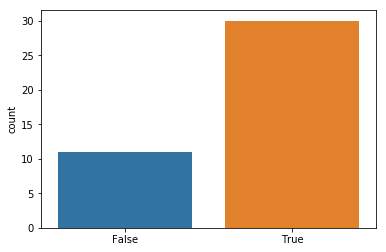

In [151]:
ax = sns.countplot(real_ups[predicted_ups])

In [152]:
pd.value_counts(real_ups[predicted_ups])

True     30
False    11
dtype: int64

In [136]:
model.save('SPY_model.hdf5', overwrite=True)

# Visualize returns

In [153]:
print('Full data size: ', binary_data.shape[0], ' rows')

Full data size:  4011  rows


In [154]:
print('Train data size: ', X_train.shape[0], ' rows')

Train data size:  3208  rows


In [155]:
test_returns = returns.iloc[X_train.shape[0]:]
test_returns.head()

Date
2012-10-15   -0.467191
2012-10-16   -2.913304
2012-10-17   -3.673233
2012-10-18   -3.104019
2012-10-19   -1.443221
Name: Return, dtype: float64

In [156]:
real_returns = test_returns[predicted_ups]

In [157]:
np.sum(real_returns[real_returns < 0])

-21.611492500428614

In [158]:
np.sum(real_returns[real_returns > 0])

52.271080904830065

In [159]:
np.sum(real_returns)

30.65958840440145

c:\programdata\anaconda3\envs\trading3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


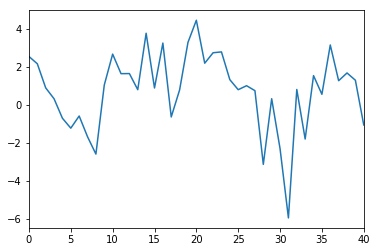

In [160]:
sns.tsplot(real_returns)

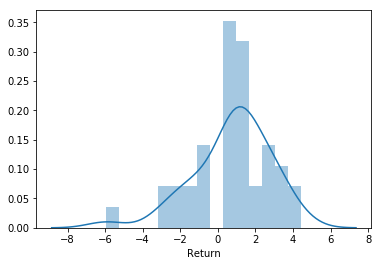

In [161]:
sns.distplot(real_returns, bins=15)

In [162]:
np.sum(test_returns[test_returns < 0])

-447.5158694480812

In [163]:
np.sum(test_returns[test_returns > 0])

609.7892734506654

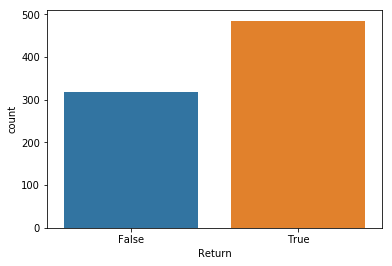

In [164]:
sns.countplot(test_returns > 0)